# Data Preprocessing

The data is from October 4, 2013 to November 7, 2015.

In [1306]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("data_preprocessed.csv", sep = ";").\
    rename(columns = {"Unnamed: 0": "obs"}).\
    drop(["DEMAND_DATE"], axis = 1)

data_copy = data.copy()

# index of the needed data: (0:33, 103:223, 225:)
data = pd.concat((data.iloc[:, 0:33], data.iloc[:, 103:223], data.iloc[:, 225:]), axis = 1)

diff_data = pd.concat((data.iloc[:,0:23].iloc[1:],\
                       data.iloc[:,23:153].diff().iloc[1:], data.iloc[:, 153:].iloc[1:]), axis = 1)

# Preprocess the data for ML models
def process_dat_ml(lookback, food, scale, window_size, dat):
    curr_index = lookback

    current_date = dat.iloc[lookback][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
    dat_X = current_date.to_numpy()

    # Add cumulative demand for the food on previous days as a feature
    prev_cum_demand = dat.iloc[lookback][[food + "_CUM_DEMAND_T2",food + "_CUM_DEMAND_T3",food + "_CUM_DEMAND_T4",\
                                          food + "_CUM_DEMAND_T5",food + "_CUM_DEMAND_T6",food + "_CUM_DEMAND_T7"]].\
                                          to_numpy()
    dat_X = np.concat((dat_X, prev_cum_demand))

    # Add the difference between highest and lowest demand for the food in the last 7 days
    prev_hml = dat.iloc[lookback][[food + "_HML_DEMAND_T7"]].to_numpy()
    dat_X = np.concat((dat_X, prev_hml))

    # Add the number of previous 7 days of which the demand is higher than average 7D demand
    # for fish products, meat, and the food we are predicting demand for
    prev_high_demand = dat.iloc[lookback][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                           "TOTAL_FISCHPROD_NO_DAYS_ABOVE_7D_MEAN",\
                                            "TOTAL_FLEISCH_NO_DAYS_ABOVE_7D_MEAN",\
                                                "TOTAL_NO_DAYS_ABOVE_7D_MEAN"]].to_numpy()
    dat_X = np.concat((dat_X, prev_high_demand))

    # Add average demand for the food, fish prod, meat, and average total demand
    # in the previous 2,3, and 4 same weekdays
    prev_week_demand = dat.iloc[lookback][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4",\
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W4",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W4",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
    dat_X = np.concat((dat_X, prev_week_demand))

    # Add weather data
    current_weather = dat.iloc[lookback][153:173].to_numpy()
    dat_X = np.concat((dat_X, current_weather))

    # Add dummy variables holiday and weekend
    current_event = dat.iloc[lookback][218:220].to_numpy()
    dat_X = np.concat((dat_X, current_event))

    # Add demand for each of the 7 food in the previous lookback days
    for i in range(lookback):
        food_demand = dat.iloc[curr_index - i - 1][["CALAMARI", "FISCH", "GARNELEN", "HAEHNCHEN",\
                                                    "KOEFTE", "LAMM", "STEAK"]].to_numpy()
        dat_X = np.concat((dat_X, food_demand))

    dat_Y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)

    while curr_index < (len(dat) - window_size):
        curr_index += 1

        current_date = dat.iloc[curr_index][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
        dat_x = current_date.to_numpy()

        # Add cumulative demand for the food on previous days as a feature
        prev_cum_demand = dat.iloc[curr_index][[food + "_CUM_DEMAND_T2",food + "_CUM_DEMAND_T3",food + "_CUM_DEMAND_T4",\
                                          food + "_CUM_DEMAND_T5",food + "_CUM_DEMAND_T6",food + "_CUM_DEMAND_T7"]].\
                                          to_numpy()
        dat_x = np.concat((dat_x, prev_cum_demand))

        # Add the difference between highest and lowest demand for the food in the last 7 days
        prev_hml = dat.iloc[curr_index][[food + "_HML_DEMAND_T7"]].to_numpy()
        dat_x = np.concat((dat_x, prev_hml))

        # Add the number of previous 7 days of which the demand is higher than average 7D demand
        # for fish products, meat, and the food we are predicting demand for
        prev_high_demand = dat.iloc[curr_index][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                           "TOTAL_FISCHPROD_NO_DAYS_ABOVE_7D_MEAN",\
                                            "TOTAL_FLEISCH_NO_DAYS_ABOVE_7D_MEAN",\
                                                "TOTAL_NO_DAYS_ABOVE_7D_MEAN"]].to_numpy()
        dat_x = np.concat((dat_x, prev_high_demand))

        # Add average demand for the food, fish prod, meat, and average total demand
        # in the previous 2,3, and 4 same weekdays
        prev_week_demand = dat.iloc[curr_index][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4",\
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_FISCHPROD_MEAN_SAME_WDAY_DEMANDS_W4",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_FLEISCH_MEAN_SAME_WDAY_DEMANDS_W4",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W2",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W3",
                                            "TOTAL_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
        dat_x = np.concat((dat_x, prev_week_demand))

        # Add weather data
        current_weather = dat.iloc[curr_index][153:173].to_numpy()
        dat_x = np.concat((dat_x, current_weather))

        # Add dummy variables holiday and weekend
        current_event = dat.iloc[curr_index][218:220].to_numpy()
        dat_x = np.concat((dat_x, current_event))

        # Add demand for each of the 7 food in the previous lookback days
        for i in range(lookback):
            food_demand = dat.iloc[curr_index - i - 1][["CALAMARI", "FISCH", "GARNELEN", "HAEHNCHEN",\
                                                    "KOEFTE", "LAMM", "STEAK"]].to_numpy()
            dat_x = np.concat((dat_x, food_demand))
        
        dat_y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)
        
        dat_X = np.vstack((dat_X, dat_x))
        dat_Y = np.vstack((dat_Y, dat_y))

    if scale:
        scaler = StandardScaler()
        scaled_dat_X = scaler.fit_transform(dat_X)
        return scaled_dat_X, dat_Y
    
    else:
        return dat_X, dat_Y


def process_dat_ml_1(lookback, food, scale, window_size, dat):
    curr_index = lookback

    current_date = dat.iloc[lookback][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
    dat_X = current_date.to_numpy()

    # Add cumulative demand for the food on previous days as a feature
    prev_cum_demand = dat.iloc[lookback][[food + "_CUM_DEMAND_T2",food + "_CUM_DEMAND_T3",food + "_CUM_DEMAND_T4",\
                                          food + "_CUM_DEMAND_T5",food + "_CUM_DEMAND_T6",food + "_CUM_DEMAND_T7"]].\
                                          to_numpy()
    dat_X = np.concat((dat_X, prev_cum_demand))

    # Add the difference between highest and lowest demand for the food in the last 7 days
    prev_hml = dat.iloc[lookback][[food + "_HML_DEMAND_T7"]].to_numpy()
    dat_X = np.concat((dat_X, prev_hml))

    # Add the number of previous 7 days of which the demand is higher than average 7D demand
    # for the food we are predicting demand for
    prev_high_demand = dat.iloc[lookback][[food + "_NO_DAYS_ABOVE_7D_MEAN"]].to_numpy()
    dat_X = np.concat((dat_X, prev_high_demand))

    # Add average demand for the food in the previous 2,3, and 4 same weekdays
    prev_week_demand = dat.iloc[lookback][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
    dat_X = np.concat((dat_X, prev_week_demand))

    # Add weather data
    current_weather = dat.iloc[lookback][153:173].to_numpy()
    dat_X = np.concat((dat_X, current_weather))

    # Add dummy variables holiday and weekend
    current_event = dat.iloc[lookback][218:220].to_numpy()
    dat_X = np.concat((dat_X, current_event))

    # Add demand for the food in the previous lookback days
    for i in range(lookback):
        food_demand = dat.iloc[curr_index - i - 1][[food]].to_numpy()
        dat_X = np.concat((dat_X, food_demand))

    dat_Y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)

    while curr_index < (len(dat) - window_size):
        curr_index += 1

        current_date = dat.iloc[curr_index][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
        dat_x = current_date.to_numpy()

        # Add cumulative demand for the food on previous days as a feature
        prev_cum_demand = dat.iloc[curr_index][[food + "_CUM_DEMAND_T2",food + "_CUM_DEMAND_T3",food + "_CUM_DEMAND_T4",\
                                          food + "_CUM_DEMAND_T5",food + "_CUM_DEMAND_T6",food + "_CUM_DEMAND_T7"]].\
                                          to_numpy()
        dat_x = np.concat((dat_x, prev_cum_demand))

        # Add the difference between highest and lowest demand for the food in the last 7 days
        prev_hml = dat.iloc[curr_index][[food + "_HML_DEMAND_T7"]].to_numpy()
        dat_x = np.concat((dat_x, prev_hml))

        # Add the number of previous 7 days of which the demand is higher than average 7D demand
        # for the food we are predicting demand for
        prev_high_demand = dat.iloc[curr_index][[food + "_NO_DAYS_ABOVE_7D_MEAN"]].to_numpy()
        dat_x = np.concat((dat_x, prev_high_demand))

        # Add average demand for the food in the previous 2,3, and 4 same weekdays
        prev_week_demand = dat.iloc[curr_index][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
        dat_x = np.concat((dat_x, prev_week_demand))

        # Add weather data
        current_weather = dat.iloc[curr_index][153:173].to_numpy()
        dat_x = np.concat((dat_x, current_weather))

        # Add dummy variables holiday and weekend
        current_event = dat.iloc[curr_index][218:220].to_numpy()
        dat_x = np.concat((dat_x, current_event))

        # Add demand for the food in the previous lookback days
        for i in range(lookback):
            food_demand = dat.iloc[curr_index - i - 1][[food]].to_numpy()
            dat_x = np.concat((dat_x, food_demand))
        
        dat_y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)
        
        dat_X = np.vstack((dat_X, dat_x))
        dat_Y = np.vstack((dat_Y, dat_y))

    if scale:
        scaler = StandardScaler()
        scaled_dat_X = scaler.fit_transform(dat_X)
        return scaled_dat_X, dat_Y
    
    else:
        return dat_X, dat_Y


def process_dat_ml_2(lookback, food, scale, window_size, dat):
    curr_index = lookback

    current_date = dat.iloc[lookback][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
    dat_X = current_date.to_numpy()

    # Add average demand for the food in the previous 2,3, and 4 same weekdays
    prev_week_demand = dat.iloc[lookback][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
    dat_X = np.concat((dat_X, prev_week_demand))

    # Add weather data (153:218, 153:173)
    current_weather = dat.iloc[lookback][153:218].to_numpy()
    dat_X = np.concat((dat_X, current_weather))

    # Add dummy variables holiday and weekend
    current_event = dat.iloc[lookback][218:220].to_numpy()
    dat_X = np.concat((dat_X, current_event))

    # Add demand for the food in the previous lookback days
    for i in range(lookback):
        food_demand = dat.iloc[curr_index - (lookback - i)][[food]].to_numpy()
        dat_X = np.concat((dat_X, food_demand))

    dat_Y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)

    while curr_index < (len(dat) - window_size):
        curr_index += 1

        current_date = dat.iloc[curr_index][["Montag","Dienstag","Mittwoch","Donnerstag","Freitag","Samstag","Sonntag",\
                                      "MONTH_JAN","MONTH_FEB","MONTH_MAR","MONTH_APR","MONTH_MAY","MONTH_JUN","MONTH_JUL",\
                                      "MONTH_AUG","MONTH_SEP","MONTH_OCT","MONTH_NOV","MONTH_DEC"]]
        dat_x = current_date.to_numpy()

        # Add average demand for the food in the previous 2,3, and 4 same weekdays
        prev_week_demand = dat.iloc[curr_index][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                           food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                            food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
        dat_x = np.concat((dat_x, prev_week_demand))

        # Add weather data
        current_weather = dat.iloc[curr_index][153:218].to_numpy()
        dat_x = np.concat((dat_x, current_weather))

        # Add dummy variables holiday and weekend
        current_event = dat.iloc[curr_index][218:220].to_numpy()
        dat_x = np.concat((dat_x, current_event))

        # Add demand for the food in the previous lookback days
        for i in range(lookback):
            food_demand = dat.iloc[curr_index - (lookback - i)][[food]].to_numpy()
            dat_x = np.concat((dat_x, food_demand))
        
        dat_y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)
        
        dat_X = np.vstack((dat_X, dat_x))
        dat_Y = np.vstack((dat_Y, dat_y))

    if scale:
        scaler = StandardScaler()
        scaled_dat_X = scaler.fit_transform(dat_X)
        return scaled_dat_X, dat_Y
    
    else:
        return dat_X, dat_Y


# Preprocess the data for DL models like LSTM and TFT
def process_dat_dl(seq_length, food, scale, window_size, dat = data_copy):
    curr_index = seq_length - 1
    # Date information index 1:20
    init_arr = dat.iloc[curr_index, 1:20].to_numpy()
    # Prev 7 day demand for this food
    prev_7_d = dat.iloc[curr_index][[food + "_DEMAND_T1", food + "_DEMAND_T2",\
                                     food + "_DEMAND_T3", food + "_DEMAND_T4",\
                                     food + "_DEMAND_T5", food + "_DEMAND_T6",\
                                        food + "_DEMAND_T7"]].to_numpy()
    init_arr = np.concat((init_arr, prev_7_d))
    # prev 7 day cumulative demands
    prev_7_cd = dat.iloc[curr_index][[food + "_CUM_DEMAND_T2", food + "_CUM_DEMAND_T3",\
                                      food + "_CUM_DEMAND_T4", food + "_CUM_DEMAND_T5",\
                                      food + "_CUM_DEMAND_T6", food + "_CUM_DEMAND_T7"]].to_numpy()
    init_arr = np.concat((init_arr, prev_7_cd))
    # High Minus Low demand in previous 7 days
    prev_hml = dat.iloc[curr_index][[food + "_HML_DEMAND_T7"]].to_numpy()
    init_arr = np.concat((init_arr, prev_hml))
    # No. of previous 7 days above and below previous 7D demand
    prev_hl_d = dat.iloc[curr_index][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                        food + "_NO_DAYS_BELOW_7D_MEAN"]].to_numpy()
    init_arr = np.concat((init_arr, prev_hl_d))
    # Mean of demands from previous 2,3, or 4 same weekdays
    prev_week_d = dat.iloc[curr_index][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
    init_arr = np.concat((init_arr, prev_week_d))
    # Weather information for current and previous 7 days (225:245)
    prev_weather = dat.iloc[curr_index, 225:245].to_numpy()
    init_arr = np.concat((init_arr, prev_weather))
    # holiday or weekend
    holiday = dat.iloc[curr_index, -2:].to_numpy()
    init_arr = np.concat((init_arr, holiday))

    # Input size of 60
    input_size = init_arr.shape[0]

    for i in range(seq_length - 1):
        # Date information index 1:20
        x = dat.iloc[curr_index - i - 1, 1:20].to_numpy()
        # Prev 7 day demand for this food
        prev_7_d = dat.iloc[curr_index - i - 1][[food + "_DEMAND_T1", food + "_DEMAND_T2",\
                                     food + "_DEMAND_T3", food + "_DEMAND_T4",\
                                     food + "_DEMAND_T5", food + "_DEMAND_T6",\
                                        food + "_DEMAND_T7"]].to_numpy()
        x = np.concat((x, prev_7_d))
        # prev 7 day cumulative demands
        prev_7_cd = dat.iloc[curr_index - i - 1][[food + "_CUM_DEMAND_T2", food + "_CUM_DEMAND_T3",\
                                      food + "_CUM_DEMAND_T4", food + "_CUM_DEMAND_T5",\
                                      food + "_CUM_DEMAND_T6", food + "_CUM_DEMAND_T7"]].to_numpy()
        x = np.concat((x, prev_7_cd))
        # High Minus Low demand in previous 7 days
        prev_hml = dat.iloc[curr_index - i - 1][[food + "_HML_DEMAND_T7"]].to_numpy()
        x = np.concat((x, prev_hml))
        # No. of previous 7 days above and below previous 7D demand
        prev_hl_d = dat.iloc[curr_index - i - 1][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                        food + "_NO_DAYS_BELOW_7D_MEAN"]].to_numpy()
        x = np.concat((x, prev_hl_d))
        # Mean of demands from previous 2,3, or 4 same weekdays
        prev_week_d = dat.iloc[curr_index - i - 1][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
        x = np.concat((x, prev_week_d))
        # Weather information for current and previous 7 days (225:245)
        prev_weather = dat.iloc[curr_index - i - 1, 225:245].to_numpy()
        x = np.concat((x, prev_weather))
        # holiday or weekend
        holiday = dat.iloc[curr_index - i - 1, -2:].to_numpy()
        x = np.concat((x, holiday))

        init_arr = np.vstack((x, init_arr))

    batch = []

    if scale:
        scaler = StandardScaler()
        scaled_init_arr = scaler.fit_transform(init_arr)
        batch.append(scaled_init_arr)
    else:
        batch.append(init_arr)

    dat_Y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)

    while curr_index < (len(dat) - window_size):
        curr_index += 1
        # Date information index 1:20
        arr = dat.iloc[curr_index, 1:20].to_numpy()

        # Prev 7 day demand for this food
        prev_7_d = dat.iloc[curr_index][[food + "_DEMAND_T1", food + "_DEMAND_T2",\
                                     food + "_DEMAND_T3", food + "_DEMAND_T4",\
                                     food + "_DEMAND_T5", food + "_DEMAND_T6",\
                                        food + "_DEMAND_T7"]].to_numpy()
        arr = np.concat((arr, prev_7_d))

        # prev 7 day cumulative demands
        prev_7_cd = dat.iloc[curr_index][[food + "_CUM_DEMAND_T2", food + "_CUM_DEMAND_T3",\
                                      food + "_CUM_DEMAND_T4", food + "_CUM_DEMAND_T5",\
                                      food + "_CUM_DEMAND_T6", food + "_CUM_DEMAND_T7"]].to_numpy()
        arr = np.concat((arr, prev_7_cd))

        # High Minus Low demand in previous 7 days
        prev_hml = dat.iloc[curr_index][[food + "_HML_DEMAND_T7"]].to_numpy()
        arr = np.concat((arr, prev_hml))

        # No. of previous 7 days above and below previous 7D demand
        prev_hl_d = dat.iloc[curr_index][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                        food + "_NO_DAYS_BELOW_7D_MEAN"]].to_numpy()
        arr = np.concat((arr, prev_hl_d))

        # Mean of demands from previous 2,3, or 4 same weekdays
        prev_week_d = dat.iloc[curr_index][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
        arr = np.concat((arr, prev_week_d))

        # Weather information for current and previous 7 days (225:245)
        prev_weather = dat.iloc[curr_index, 225:245].to_numpy()
        arr = np.concat((arr, prev_weather))

        # holiday or weekend
        holiday = dat.iloc[curr_index, -2:].to_numpy()
        arr = np.concat((arr, holiday))

        for i in range(seq_length - 1):
            # Date information index 1:20
            arr_x = dat.iloc[curr_index - i - 1, 1:20].to_numpy()

            # Prev 7 day demand for this food
            prev_7_d = dat.iloc[curr_index - i - 1][[food + "_DEMAND_T1", food + "_DEMAND_T2",\
                                     food + "_DEMAND_T3", food + "_DEMAND_T4",\
                                     food + "_DEMAND_T5", food + "_DEMAND_T6",\
                                        food + "_DEMAND_T7"]].to_numpy()
            arr_x = np.concat((arr_x, prev_7_d))

            # prev 7 day cumulative demands
            prev_7_cd = dat.iloc[curr_index - i - 1][[food + "_CUM_DEMAND_T2", food + "_CUM_DEMAND_T3",\
                                      food + "_CUM_DEMAND_T4", food + "_CUM_DEMAND_T5",\
                                      food + "_CUM_DEMAND_T6", food + "_CUM_DEMAND_T7"]].to_numpy()
            arr_x = np.concat((arr_x, prev_7_cd))

            # High Minus Low demand in previous 7 days
            prev_hml = dat.iloc[curr_index - i - 1][[food + "_HML_DEMAND_T7"]].to_numpy()
            arr_x = np.concat((arr_x, prev_hml))

            # No. of previous 7 days above and below previous 7D demand
            prev_hl_d = dat.iloc[curr_index - i - 1][[food + "_NO_DAYS_ABOVE_7D_MEAN",\
                                        food + "_NO_DAYS_BELOW_7D_MEAN"]].to_numpy()
            arr_x = np.concat((arr_x, prev_hl_d))

            # Mean of demands from previous 2,3, or 4 same weekdays
            prev_week_d = dat.iloc[curr_index - i - 1][[food + "_MEAN_SAME_WDAY_DEMANDS_W2",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W3",\
                                        food + "_MEAN_SAME_WDAY_DEMANDS_W4"]].to_numpy()
            arr_x = np.concat((arr_x, prev_week_d))

            # Weather information for current and previous 7 days (225:245)
            prev_weather = dat.iloc[curr_index - i - 1, 225:245].to_numpy()
            arr_x = np.concat((arr_x, prev_weather))

            # holiday or weekend
            holiday = dat.iloc[curr_index - i - 1, -2:].to_numpy()
            arr_x = np.concat((arr_x, holiday))

            arr = np.vstack((arr_x, arr))
        
        if scale:
            scaler = StandardScaler()
            scaled_arr = scaler.fit_transform(arr)
            batch.append(scaled_arr)
        else:
            batch.append(arr)
        
        dat_y = dat.iloc[curr_index: curr_index + window_size][[food]].to_numpy().reshape(1, window_size)
        dat_Y = np.vstack((dat_Y, dat_y))
    
    return np.array(batch), dat_Y


# Fitting Machine Learning Models

The machine learning models considered are SVR, kernel ridge regression, RF, and GBDT. We will scale the data for SVR and kernel ridge regression and try recursive feature elimination for models that calculate feature importance to see which perform the best. We first try non-differenced data to see the performance on the test set. We will use expanding window approach for cross validation (i.e. time series split in sklearn) and the same approach for evaluating the test set. The number of days forecasted into the future will be tested for performance to see how long we can predict into the future without losing performance.

## Kernel Ridge (Non-differenced)

In [711]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import sklearn.metrics as metrics

def kernel_ridge_model(train_X, train_Y, splits, gap):

    tss = TimeSeriesSplit(n_splits = splits, test_size= 20, gap = gap)
    estimator = KernelRidge()
    param_grid = {"alpha": [0.1,0.2,1,5,10],\
                  "kernel": ["rbf","linear"],\
                    "gamma": [0.01,0.05,0.1,0.5,1]}
    grid_search = GridSearchCV(estimator = estimator, param_grid=param_grid, cv = tss,\
                               scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    return grid_search.best_estimator_

def evaluate_kr(lookback, food, window_size, test_period, metric, process, data):
    dat = process(lookback=lookback, food = food, scale=True, \
                         window_size=window_size, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window_size <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test]
        est = kernel_ridge_model(train_X, train_Y, 6, 28)
        pred = np.concat((pred,est.predict(dat[0][start_test+window_size-1].reshape(1, dat[0].shape[1]))\
                          .flatten()))
        true_val = np.concat((true_val,dat[1][start_test+window_size-1]))
        start_test = start_test + window_size

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))


In [712]:

# CALAMARI

kr_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window_size in kr_cal["window"]:
    errors = []
    errors.append(evaluate_kr(lookback = 28, food = "CALAMARI", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.mean_absolute_error, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "CALAMARI", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.r2_score, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "CALAMARI", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.root_mean_squared_error, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "CALAMARI", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.root_mean_squared_error, process = process_dat_ml_1, data = data)[1])
    kr_cal["value"].append(errors)

# STEAK

kr_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window_size in kr_steak["window"]:
    errors = []
    errors.append(evaluate_kr(lookback = 28, food = "STEAK", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.mean_absolute_error, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "STEAK", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.r2_score, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "STEAK", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.root_mean_squared_error, process = process_dat_ml_1, data = data)[0])
    errors.append(evaluate_kr(lookback = 28, food = "STEAK", window_size=window_size, test_period=112 + (window_size - 1),\
                              metric = metrics.root_mean_squared_error, process = process_dat_ml_1, data = data)[1])
    kr_steak["value"].append(errors)

## Kernel Ridge step-wise (Non-differenced)

In [669]:
def evaluate_krsw(lookback, food, test_period, metric, data, window):
    dat = process_dat_ml_2(lookback=lookback, food = food, scale=True, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test]
        est = kernel_ridge_model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1])).flatten()
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val,dat[1][start_test]))
        for i in range(window - 1):
            curr_feature = dat[0][start_test + i + 1]
            curr_feature[-1] = curr_pred[0]
            curr_pred = est.predict(curr_feature.reshape(1, dat[0].shape[1])).flatten()
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test + i + 1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))



In [713]:

# CALAMARI

krsw_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in krsw_cal["window"]:
    errors = []
    errors.append(evaluate_krsw(lookback = 28, food = "CALAMARI", test_period=112,\
              metric = metrics.mean_absolute_error, data = data, window = window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "CALAMARI", test_period=112,\
              metric = metrics.r2_score, data = data, window=window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "CALAMARI", test_period=112,\
              metric = metrics.root_mean_squared_error, data = data, window=window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "CALAMARI", test_period=112,\
              metric = metrics.root_mean_squared_error, data = data, window=window)[1])
    krsw_cal["value"].append(errors)

# STEAK

krsw_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in krsw_steak["window"]:
    errors = []
    errors.append(evaluate_krsw(lookback = 28, food = "STEAK", test_period=112,\
              metric = metrics.mean_absolute_error, data = data, window = window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "STEAK", test_period=112,\
              metric = metrics.r2_score, data = data, window=window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "STEAK", test_period=112,\
              metric = metrics.root_mean_squared_error, data = data, window=window)[0])
    errors.append(evaluate_krsw(lookback = 28, food = "STEAK", test_period=112,\
              metric = metrics.root_mean_squared_error, data = data, window=window)[1])
    krsw_steak["value"].append(errors)


## Support Vector Regression (Non-Differenced)

In [1731]:
from sklearn.svm import SVR

def svr_model(train_X, train_Y, splits, gap):
    tss = TimeSeriesSplit(n_splits = splits, test_size= 20, gap = gap)
    estimator = SVR()
    param_grid = {"C": [0.1,1,10,100], "kernel": ["rbf", "sigmoid"]}
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, \
                               scoring="neg_root_mean_squared_error",\
                                cv = tss, n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    return grid_search.best_estimator_

def evaluate_svr(lookback, food, test_period, metric, process, data, window):
    dat = process(lookback=lookback, food = food, scale=True, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test].flatten()
        est = svr_model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1]))
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val, dat[1][start_test]))
        
        for i in range(window - 1):
            train_X = train_X[:-1]
            train_Y = np.roll(train_Y, shift = -1)[:-1]
            est = svr_model(train_X, train_Y, 6, 28)
            curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1]))
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test+i+1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val)), pred_round, true_val


In [861]:

# CALAMARI

svr_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in svr_cal["window"]:
    errors = []
    errors.append(evaluate_svr(lookback=28, food="CALAMARI",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="CALAMARI",\
                               test_period=112, metric=metrics.r2_score,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="CALAMARI",\
                               test_period=112, metric=metrics.root_mean_squared_error,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="CALAMARI",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[1])
    svr_cal["value"].append(errors)

# STEAK

svr_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in svr_steak["window"]:
    errors = []
    errors.append(evaluate_svr(lookback=28, food="STEAK",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="STEAK",\
                               test_period=112, metric=metrics.r2_score,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="STEAK",\
                               test_period=112, metric=metrics.root_mean_squared_error,\
                                process = process_dat_ml_1, data = data, window = window)[0])
    errors.append(evaluate_svr(lookback=28, food="STEAK",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[1])
    svr_steak["value"].append(errors)


## Support Vector Regression step-wise

In [1733]:
from sklearn.feature_selection import RFECV

def svr_model_lf(train_X, train_Y, splits, gap):
    tss = TimeSeriesSplit(n_splits = splits, test_size= 20, gap = gap)
    estimator = SVR(kernel = "linear")
    cv_est = RFECV(estimator=estimator, step = 5, cv = tss, n_jobs=-1,\
                   scoring="neg_mean_squared_error")
    new_est = cv_est.fit(train_X, train_Y)

    return new_est
    
def evaluate_svrsw(lookback, food, test_period, metric, data, window, model):
    dat = process_dat_ml_2(lookback=lookback, food = food, scale=True, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test].flatten()
        est = model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1])).flatten()
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val,dat[1][start_test]))
        for i in range(window - 1):
            curr_feature = dat[0][start_test + i + 1]
            curr_feature[-1] = curr_pred[0]
            curr_pred = est.predict(curr_feature.reshape(1, dat[0].shape[1])).flatten()
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test + i + 1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val)), pred_round, true_val


In [976]:

# CALAMARI

svrsw_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in svrsw_cal["window"]:
    errors = []
    errors.append(evaluate_svrsw(lookback=28, food = "CALAMARI", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "CALAMARI", test_period=112,\
               metric = metrics.r2_score, data = data, window = window, model = svr_model)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "CALAMARI", test_period=112,\
               metric = metrics.root_mean_squared_error, data = data, window = window, model = svr_model)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "CALAMARI", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model)[1])
    svrsw_cal["value"].append(errors)

# STEAK

svrsw_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in svrsw_steak["window"]:
    errors = []
    errors.append(evaluate_svrsw(lookback=28, food = "STEAK", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model_lf)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "STEAK", test_period=112,\
               metric = metrics.r2_score, data = data, window = window, model = svr_model_lf)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "STEAK", test_period=112,\
               metric = metrics.root_mean_squared_error, data = data, window = window, model = svr_model_lf)[0])
    errors.append(evaluate_svrsw(lookback=28, food = "STEAK", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model_lf)[1])
    svrsw_steak["value"].append(errors)

## Random Forest Model

In [981]:
from sklearn.ensemble import RandomForestRegressor

def rf_model(train_X, train_Y, splits, gap):
    tss = TimeSeriesSplit(n_splits = splits, test_size= 20, gap = gap)
    estimator = RandomForestRegressor(n_estimators=700)
    param_grid = {"max_depth": [5,10],\
                  "max_features": ["sqrt", "log2"]}
    grid_search = GridSearchCV(estimator = estimator, param_grid=param_grid, cv = tss,\
                               scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    return grid_search.best_estimator_


def evaluate_rf(lookback, food, window_size, test_period, metric, process, data):
    dat = process(lookback=lookback, food = food, scale=False, \
                         window_size=window_size, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window_size <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test]
        est = rf_model(train_X, train_Y, 6, 28)
        pred = np.concat((pred,est.predict(dat[0][start_test+window_size-1].reshape(1, dat[0].shape[1]))\
                          .flatten()))
        true_val = np.concat((true_val,dat[1][start_test+window_size-1]))
        start_test = start_test + window_size

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))



In [982]:

# CALAMARI

rf_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in rf_cal["window"]:
    errors = []
    errors.append(evaluate_rf(lookback = 28, food = "CALAMARI", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.mean_absolute_error, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "CALAMARI", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.r2_score, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "CALAMARI", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.root_mean_squared_error, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "CALAMARI", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.mean_absolute_error, process=process_dat_ml_1, data = data)[1])
    rf_cal["value"].append(errors)

# STEAK

rf_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in rf_steak["window"]:
    errors = []
    errors.append(evaluate_rf(lookback = 28, food = "STEAK", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.mean_absolute_error, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "STEAK", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.r2_score, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "STEAK", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.root_mean_squared_error, process=process_dat_ml_1, data = data)[0])
    errors.append(evaluate_rf(lookback = 28, food = "STEAK", window_size = window, test_period = 112 + (window_size - 1), \
            metric = metrics.mean_absolute_error, process=process_dat_ml_1, data = data)[1])
    rf_steak["value"].append(errors)

## Random Forest Model step-wise

In [1086]:
def evaluate_rfsw(lookback, food, test_period, metric, data, window):
    dat = process_dat_ml_2(lookback=lookback, food = food, scale=False, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test].flatten()
        est = rf_model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1])).flatten()
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val,dat[1][start_test]))
        for i in range(window - 1):
            curr_feature = dat[0][start_test + i + 1]
            curr_feature[-1] = curr_pred[0]
            curr_pred = est.predict(curr_feature.reshape(1, dat[0].shape[1])).flatten()
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test + i + 1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))


In [1087]:
# CALAMARI

rfsw_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in rfsw_cal["window"]:
    errors = []
    errors.append(evaluate_rfsw(lookback=28, food="CALAMARI", test_period=112,\
              metric = metrics.mean_absolute_error, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="CALAMARI", test_period=112,\
              metric = metrics.r2_score, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="CALAMARI", test_period=112,\
              metric = metrics.root_mean_squared_error, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="CALAMARI", test_period=112,\
              metric = metrics.mean_absolute_error, data=data, window=window)[1])
    rfsw_cal["value"].append(errors)

# STEAK

rfsw_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in rfsw_steak["window"]:
    errors = []
    errors.append(evaluate_rfsw(lookback=28, food="STEAK", test_period=112,\
              metric = metrics.mean_absolute_error, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="STEAK", test_period=112,\
              metric = metrics.r2_score, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="STEAK", test_period=112,\
              metric = metrics.root_mean_squared_error, data=data, window=window)[0])
    errors.append(evaluate_rfsw(lookback=28, food="STEAK", test_period=112,\
              metric = metrics.mean_absolute_error, data=data, window=window)[1])
    rfsw_steak["value"].append(errors)

## Gradient Boosted Decision Tree

In [708]:
from sklearn.ensemble import GradientBoostingRegressor

def gbdt_model(train_X, train_Y, splits, gap):
    tss = TimeSeriesSplit(n_splits = splits, test_size= 20, gap = gap)
    estimator = GradientBoostingRegressor(n_estimators=500, max_features="sqrt")
    param_grid = {"learning_rate": [0.05,0.1,0.4]}
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, \
                               scoring="neg_root_mean_squared_error",\
                                cv = tss, n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    return grid_search.best_estimator_

def evaluate_gbdt(lookback, food, test_period, metric, process, data, window):
    dat = process(lookback=lookback, food = food, scale=False, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test].flatten()
        est = gbdt_model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1]))
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val, dat[1][start_test]))
        
        for i in range(window - 1):
            train_X = train_X[:-1]
            train_Y = np.roll(train_Y, shift = -1)[:-1]
            est = gbdt_model(train_X, train_Y, 6, 28)
            curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1]))
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test+i+1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))



In [709]:

# CALAMARI

gbdt_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in gbdt_cal["window"]:
    errors = []
    errors.append(evaluate_gbdt(lookback=28, food = "CALAMARI", test_period=112,\
                                metric = metrics.mean_absolute_error, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "CALAMARI", test_period=112,\
                                metric = metrics.r2_score, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "CALAMARI", test_period=112,\
                                metric = metrics.root_mean_squared_error, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "CALAMARI", test_period=112,\
                                metric = metrics.mean_absolute_error, process = process_dat_ml_1,\
                                    data = data, window = window)[1])
    gbdt_cal["value"].append(errors)

# STEAK

gbdt_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in gbdt_steak["window"]:
    errors = []
    errors.append(evaluate_gbdt(lookback=28, food = "STEAK", test_period=112,\
                                metric = metrics.mean_absolute_error, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "STEAK", test_period=112,\
                                metric = metrics.r2_score, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "STEAK", test_period=112,\
                                metric = metrics.root_mean_squared_error, process = process_dat_ml_1,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdt(lookback=28, food = "STEAK", test_period=112,\
                                metric = metrics.mean_absolute_error, process = process_dat_ml_1,\
                                    data = data, window = window)[1])
    gbdt_steak["value"].append(errors)



## GBDT step-wise

In [782]:
def evaluate_gbdtsw(lookback, food, test_period, metric, data, window):
    dat = process_dat_ml_2(lookback=lookback, food = food, scale=False, \
                         window_size=1, dat=data)
    start_test = dat[0].shape[0] - test_period
    true_val = np.array([])
    pred = np.array([])
    while start_test + window <= (dat[0].shape[0]):
        train_X = dat[0][:start_test]
        train_Y = dat[1][:start_test].flatten()
        est = gbdt_model(train_X, train_Y, 6, 28)
        curr_pred = est.predict(dat[0][start_test].reshape(1, dat[0].shape[1])).flatten()
        pred = np.concat((pred, curr_pred))
        true_val = np.concat((true_val,dat[1][start_test]))
        for i in range(window - 1):
            curr_feature = dat[0][start_test + i + 1]
            curr_feature[-1] = curr_pred[0]
            curr_pred = est.predict(curr_feature.reshape(1, dat[0].shape[1])).flatten()
            pred = np.concat((pred, curr_pred))
            true_val = np.concat((true_val, dat[1][start_test + i + 1]))

        start_test = start_test + window

    pred_round = np.round(pred)
    return metric(true_val, pred), np.sum(np.abs(pred_round - true_val))


In [783]:
# CALAMARI

gbdtsw_cal = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in gbdtsw_cal["window"]:
    errors = []
    errors.append(evaluate_gbdtsw(lookback=28, food = "CALAMARI",\
                                  test_period=112, metric = metrics.mean_absolute_error,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "CALAMARI",\
                                  test_period=112, metric = metrics.r2_score,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "CALAMARI",\
                                  test_period=112, metric = metrics.root_mean_squared_error,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "CALAMARI",\
                                  test_period=112, metric = metrics.mean_absolute_error,\
                                    data = data, window = window)[1])
    gbdtsw_cal["value"].append(errors)

# STEAK

gbdtsw_steak = {"error": ["MAE", "R2", "RMSE", "Wasted Food"], "window": [3,4,5,6,7], "value": []}

for window in gbdtsw_steak["window"]:
    errors = []
    errors.append(evaluate_gbdtsw(lookback=28, food = "STEAK",\
                                  test_period=112, metric = metrics.mean_absolute_error,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "STEAK",\
                                  test_period=112, metric = metrics.r2_score,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "STEAK",\
                                  test_period=112, metric = metrics.root_mean_squared_error,\
                                    data = data, window = window)[0])
    errors.append(evaluate_gbdtsw(lookback=28, food = "STEAK",\
                                  test_period=112, metric = metrics.mean_absolute_error,\
                                    data = data, window = window)[1])
    gbdtsw_steak["value"].append(errors)


# LSTM 

## Load the preprocessed data

In [1249]:
lstm_cal_3 = process_dat_dl(seq_length=28, food = "CALAMARI", scale = True, window_size = 3)
lstm_cal_4 = process_dat_dl(seq_length=28, food = "CALAMARI", scale = True, window_size = 4)
lstm_cal_5 = process_dat_dl(seq_length=28, food = "CALAMARI", scale = True, window_size = 5)
lstm_cal_6 = process_dat_dl(seq_length=28, food = "CALAMARI", scale = True, window_size = 6)
lstm_cal_7 = process_dat_dl(seq_length=28, food = "CALAMARI", scale = True, window_size = 7)

lstm_steak_3 = process_dat_dl(seq_length=28, food = "STEAK", scale = True, window_size = 3)
lstm_steak_4 = process_dat_dl(seq_length=28, food = "STEAK", scale = True, window_size = 4)
lstm_steak_5 = process_dat_dl(seq_length=28, food = "STEAK", scale = True, window_size = 5)
lstm_steak_6 = process_dat_dl(seq_length=28, food = "STEAK", scale = True, window_size = 6)
lstm_steak_7 = process_dat_dl(seq_length=28, food = "STEAK", scale = True, window_size = 7)

## LSTM Architecture

input size of LSTM model is 60, 28 sequences for predicting the future 7 days using past 28 demand and weather information

In [1419]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM Model
class lstmModel(nn.Module):
    # hidden is number of cells in hidden layer
    def __init__(self, input, hidden, output):
        super().__init__()
        self.hidden = hidden
        self.lstm = nn.LSTM(input_size = input, hidden_size = hidden, batch_first = True, num_layers=1)
        self.linear = nn.Linear(hidden, output)
        self.dropout = nn.Dropout(0.4)

    def forward(self, input):
        out, _ = self.lstm(input)
        x = self.linear(out[:,-1,:])
        #x = self.dropout(x)
        return x



## Training

In [1607]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# data size - 113 + window_size
def LSTM_train_test(data, window_size):
    data_size = data[0].shape[0]

    # Get last 112 days as test data
    train_X = np.array(data[0][:data_size - 113 + window_size], dtype=np.float32)
    train_Y = np.array(data[1][:data_size - 113 + window_size], dtype=np.float32)

    test_X = np.array(data[0][data_size - 113 + window_size:], dtype=np.float32)
    test_Y = np.array(data[1][data_size - 113 + window_size:], dtype=np.float32)

    train_X = torch.tensor(train_X, dtype = torch.float32)
    train_Y = torch.tensor(train_Y, dtype = torch.float32)
    test_X = torch.tensor(test_X, dtype = torch.float32)
    test_Y = torch.tensor(test_Y, dtype = torch.float32)

    train_dat = TensorDataset(train_X, train_Y)
    test_dat = TensorDataset(test_X, test_Y)

    train_loader = DataLoader(train_dat, batch_size = 4, shuffle = False)
    test_loader = DataLoader(test_dat, batch_size = 4, shuffle = False)

    model = lstmModel(input = 60, hidden = 26, output = window_size)
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for _ in range(50):
        model.train()

        for x, y in train_loader:
            optimizer.zero_grad()
            mse_loss = loss(model(x), y)
            mse_loss.backward()
            optimizer.step()

    # Evaluate on test data (last 112 days)
    model.eval()
    with torch.no_grad():
        preds = []
        actual = []
        for x, y in test_loader:
            pred = model(x)
            pred = pred.numpy()
            preds.append(pred)
            actual.append(y.numpy())

    predicted = preds[0]
    actual_val = actual[0]

    for i in range(len(preds) - 1):
        predicted = np.vstack((predicted, preds[i + 1]))
        actual_val = np.vstack((actual_val, actual[i + 1]))
    
    every7d_pred = np.array([])
    every7d_true = np.array([])

    for j in range(len(predicted)):
        if j*window_size <= (len(predicted) - 1):
            every7d_pred = np.concat((every7d_pred, predicted[j*window_size]))
            every7d_true = np.concat((every7d_true, actual_val[j*window_size]))

    return  metrics.root_mean_squared_error(every7d_true, every7d_pred)


LSTM_train_test(lstm_steak_4,4)

np.float64(8.806337645625472)

# Experiments

Text(0, 0.5, 'Average Demand')

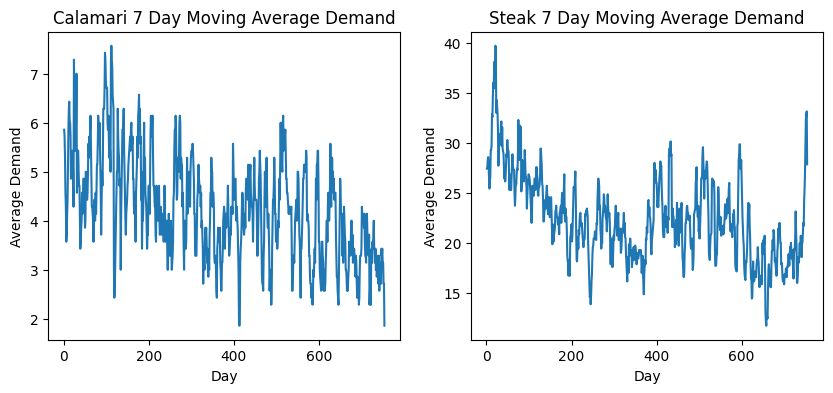

In [1377]:
import matplotlib.pyplot as plt


day = data_copy.iloc[:,0].to_numpy()

calamari_demand = data_copy.iloc[:,23]

steak_demand = data_copy.iloc[:,29]

calamari_demand_smooth = calamari_demand.rolling(7).mean().iloc[6:]

steak_demand_smooth = steak_demand.rolling(7).mean().iloc[6:]

fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(np.linspace(1, 760-6, 760-6), calamari_demand_smooth)
axs[0].set_title("Calamari 7 Day Moving Average Demand")
axs[0].set_xlabel("Day")
axs[0].set_ylabel("Average Demand")
axs[1].plot(np.linspace(1, 760-6,760-6), steak_demand_smooth)
axs[1].set_title("Steak 7 Day Moving Average Demand")
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Average Demand")

In [ ]:

calamari_last7davg = data_copy.iloc[:,108]/7
calamari_last6davg = data_copy.iloc[:,107]/6
calamari_last5davg = data_copy.iloc[:,106]/5
calamari_last4davg = data_copy.iloc[:,105]/4
calamari_last3davg = data_copy.iloc[:,104]/3

calamari_last7davg[760-112:]

def food_waste(pred_demand, true_demand):
    total = 0
    for i in range(len(pred_demand)):
        if np.round(pred_demand[i]) > true_demand[i]:
            total += np.round(pred_demand[i]) - true_demand[i]
    return total


# 94 calamari food waste for baseline method 1
# food_waste(calamari_last7davg[760-112:].to_numpy(), data_copy.iloc[:,23][760-112:].to_numpy())
best_model_calamari = evaluate_svr(lookback=28, food="CALAMARI",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[2:]

best_model_calamari_sw = evaluate_svrsw(lookback=28, food = "CALAMARI", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model)[2:]

best_model_steak = evaluate_svr(lookback=28, food="STEAK",\
                               test_period=112, metric=metrics.mean_absolute_error,\
                                process = process_dat_ml_1, data = data, window = window)[2:]

best_model_steaksw = evaluate_svrsw(lookback=28, food = "STEAK", test_period=112,\
               metric = metrics.mean_absolute_error, data = data, window = window, model = svr_model_lf)[2:]

In [1773]:
steak_last7davg = data_copy.iloc[:,144]/7
steak_last6davg = data_copy.iloc[:,143]/6
steak_last5davg = data_copy.iloc[:,142]/5
steak_last4davg = data_copy.iloc[:,141]/4
steak_last3davg = data_copy.iloc[:,140]/3


#339 steak wasted
metrics.mean_absolute_error(data_copy.iloc[:,23][760-112:].to_numpy(), calamari_last7davg[760-112:].to_numpy())
#1.67 MAE calamari
#6.5 MAE steak

np.float64(1.6709183673469388)